# Market Efficiency Analysis in Prediction Markets

This notebook analyzes the efficiency of Polymarket prediction markets using various statistical tests to evaluate whether these markets follow the "wisdom of crowds" hypothesis.

# Using the Market Efficiency Analysis Notebook
This guide will help you use the Market Efficiency Analysis Notebook to test weak-form market efficiency on Polymarket data.
## Setup and Requirements
Before running the notebook, ensure you have:

1. Installed all required dependencies:
   ```
   pip install pandas numpy matplotlib seaborn statsmodels scipy tqdm
   ```

2. Organized your data folder with the following structure:
   - `data/cleaned_election_data.csv` - Main dataset with market information
   - `data/trades/` - Directory containing trade data files

## Analysis Workflow
The notebook is organized into sections that allow you to:

### 1. Configure Market Selection
Modify the `MARKET_SELECTION` dictionary to specify which markets to analyze:

```python
MARKET_SELECTION = {
    'by_name': [
        # Add market names here, e.g., "Will Donald Trump win the 2024 US Presidential Election?"
    ],
    'by_id': [
        253591, 253597, 253642  # Add specific market IDs
    ],
    'top_n_by_volume': 5,  # Analyze top 5 markets by trading volume
    'min_volume': 0,       # Filter markets by minimum volume threshold
}
```

### 2. Single Market Analysis
To analyze a specific market in detail:

1. Set `market_id_to_analyze` to the ID of the market you want to examine
2. Run the cell to load and preprocess trade data
3. View the price series and log returns charts
4. Check the detailed efficiency test results
5. Interpret the overall efficiency score and classification

The notebook will show:
- Price series and log returns plots
- Results of random walk tests, autocorrelation tests, and runs tests
- Overall efficiency score (0-100) and classification

### 3. Batch Analysis

To analyze multiple markets at once:
1. Run the "Batch Analysis" cell which calls `run_efficiency_analysis`
2. Review the generated visualizations including:
   - Distribution of efficiency scores
   - Classification breakdown
   - Percentage of markets passing each tes
All visualizations and detailed results will be saved to the `results_dir` folder.

## Interpreting Results
### Efficiency Classifications
- **Highly Efficient (80-100)**: Markets following random walk patterns with no predictable price movements
- **Moderately Efficient (60-80)**: Markets with few predictable patterns but generally efficient
- **Slightly Inefficient (40-60)**: Markets with some predictable patterns
- **Highly Inefficient (0-40)**: Markets with significant predictable patterns and inefficiencies

### Key Tests
- **Random Walk Test**: Price series should be non-stationary (ADF test)
- **Return Stationarity Test**: Returns should be stationary
- **No Autocorrelation Test**: Returns should not have significant autocorrelation
- **Runs Test**: Sequence of returns should be random
- **AR Model Test**: Returns should not be predictable using autoregressive models

## Customization
You can modify the notebook to:

1. Change the resampling frequency (default: '1min')
2. Adjust the visualization parameters
3. Add additional efficiency tests
4. Modify the scoring algorithm by editing the `calculate_efficiency_score` function

In [8]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings

# Add parent directory to path for importing utilities
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir) if current_dir.endswith('notebooks') else current_dir
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Import utility functions
try:
    from src.utils.data_loader import load_main_dataset, load_trade_data
    print("Successfully imported data_loader utilities")
except ImportError:
    print("Warning: Could not import data_loader utilities. Some functions may not work.")
    # Define fallback functions if needed

# Import the analyzer
try:
    from src.knowledge_value.market_efficiency import MarketEfficiencyAnalyzer
except ImportError:
    print("Warning: Could not import MarketEfficiencyAnalyzer. Trying alternative path...")
    try:
        # Try relative import if we're in a notebook
        import sys
        sys.path.append('src/knowledge_value')
        from market_efficiency import MarketEfficiencyAnalyzer
    except ImportError:
        print("Error: Could not import MarketEfficiencyAnalyzer")
        
# Suppress warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Configure paths
data_dir = 'data'
results_dir = 'results/market_efficiency'
os.makedirs(results_dir, exist_ok=True)

# Initialize the analyzer
analyzer = MarketEfficiencyAnalyzer(results_dir=results_dir)

# Load market data
print("Loading market data...")
market_data = load_main_dataset('data/cleaned_election_data.csv')

if market_data is not None:
    print(f"Loaded {len(market_data)} markets")
    
    # Display available market types
    if 'event_electionType' in market_data.columns:
        election_types = market_data['event_electionType'].value_counts()
        print("\nAvailable election types:")
        for idx, (etype, count) in enumerate(election_types.items()):
            print(f"  {idx+1}. {etype}: {count} markets")
else:
    print("Failed to load market data")

# Configure market selection
MARKET_SELECTION = {
    'by_name': [
        # Add market names here
    ],
    'by_id': [
        253643
        # Add more market IDs here
    ],
    'top_n_by_volume': 0,  # Set to a number > 0 to analyze top N markets by volume
    'min_volume': 0,  # Minimum volume threshold
}


Successfully imported data_loader utilities
Loading market data...
Loaded dataset with 1048575 rows and 54 columns
Loaded 1048575 markets

Available election types:
  1.  Presidential: 197 markets
  2.  Senate: 49 markets
  3.  Presidential Primary: 48 markets
  4.  Parliamentary: 42 markets
  5.  Vice Presidential: 41 markets
  6.  Prime Minister: 24 markets
  7.  Presidential Popular Vote: 18 markets
  8.  Mayoral: 16 markets
  9.  Presidential Tipping Point: 14 markets
  10.  Balance of Power: 9 markets
  11.  Presidential Speech: 8 markets
  12.  Governor: 7 markets
  13.  Provincial: 7 markets
  14.  Electoral College: 6 markets
  15. Presidential Administration: 4 markets
  16. Electoral College: 3 markets
  17. Presidential: 2 markets
  18.  Senate Primary: 2 markets
  19. Provincial: 2 markets
  20. Prime Minister: 1 markets



# 1. Select a specific market to analyze
Choose a market ID to analyze (e.g., from the IDs in MARKET_SELECTION)


Analyzing market: Will Kanye West win the 2024 US Presidential Election? (ID: 253643)
Loading trade data...
Loaded dataset with 1048575 rows and 54 columns
Loaded 4494 trades for token 48285207411891694847413807268670593735244327770017422161322089036370055854362
Loaded 118 trades for token 61844668920737118615861173747694492670799904596778544814046771923624799983782
Loaded 4612 trades

Preprocessing trade data...
Successfully preprocessed data with 439153 time points


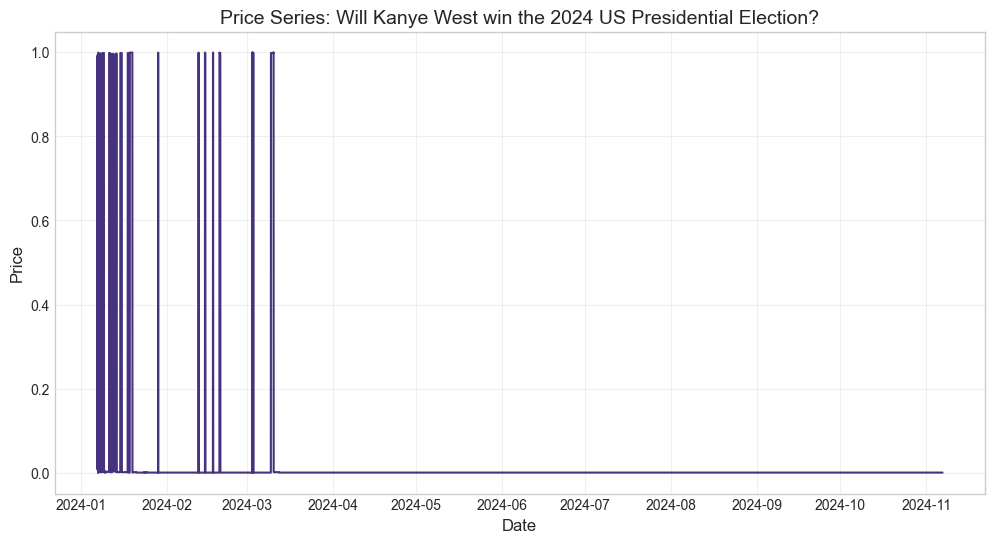

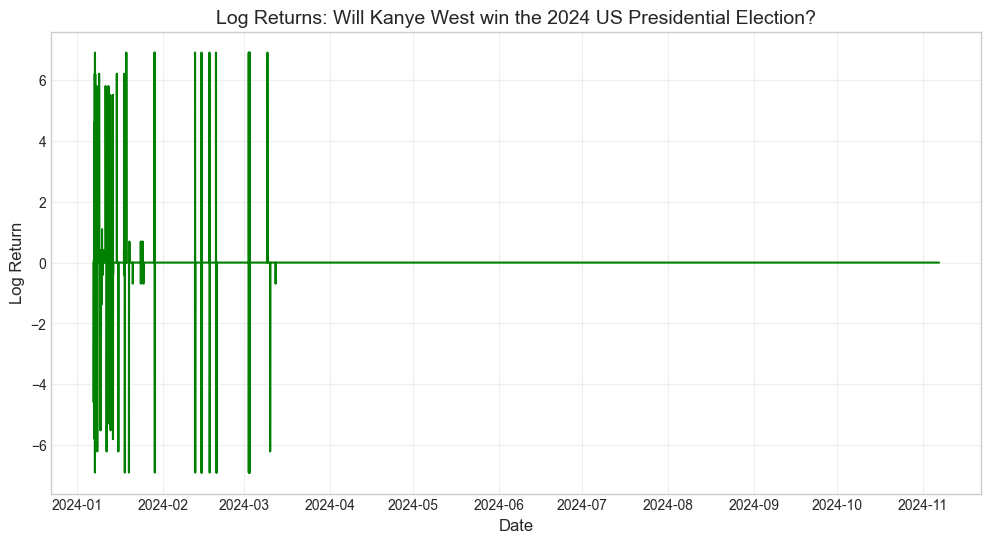


Running efficiency tests...

Efficiency Score: 25.00/100
Classification: Highly Inefficient

Detailed Test Results:
Random Walk Test: Fail (p-value: 0.0000)
Return Stationarity Test: Pass (p-value: 0.0000)
No Autocorrelation Test: Fail
  Significant lags: [1, 2, 6, 7, 8]
Runs Test for Randomness: Fail (p-value: 0.0000)
AR Model Test: Fail (p-value: 0.0000)


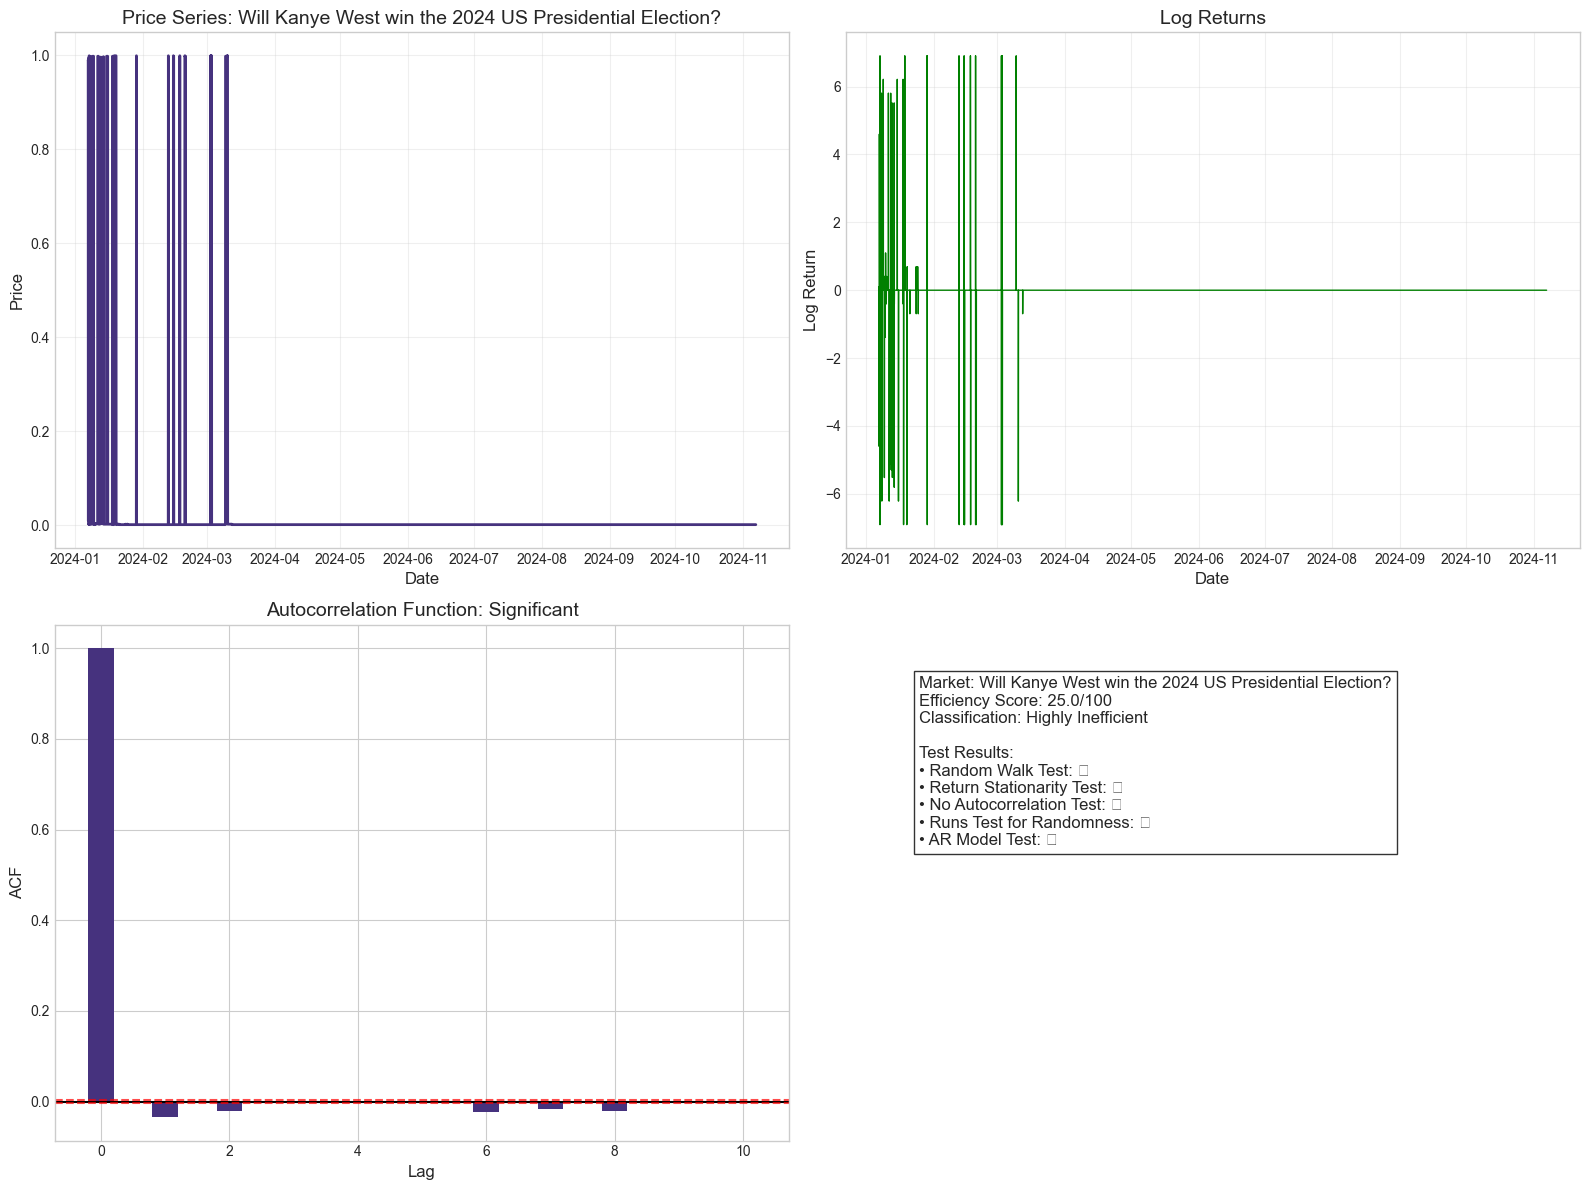

In [6]:

market_id_to_analyze = 253643  # Replace with a specific market ID

if market_id_to_analyze:
    # Find the market
    market_row = market_data[market_data['id'] == market_id_to_analyze]
    
    if not market_row.empty:
        market_name = market_row.iloc[0]['question'] if 'question' in market_row.columns else f"Market {market_id_to_analyze}"
        print(f"\nAnalyzing market: {market_name} (ID: {market_id_to_analyze})")
        
        # Load trade data
        print("Loading trade data...")
        trade_data = load_trade_data(market_id_to_analyze)
        
        if trade_data is not None and len(trade_data) >= 30:
            print(f"Loaded {len(trade_data)} trades")
            
            # Preprocess data
            print("\nPreprocessing trade data...")
            processed_data = analyzer.preprocess_market_data(trade_data)
            
            if processed_data is not None and len(processed_data) >= 30:
                print(f"Successfully preprocessed data with {len(processed_data)} time points")
                
                # Display price series
                plt.figure(figsize=(12, 6))
                plt.plot(processed_data.index, processed_data['price'])
                plt.title(f'Price Series: {market_name}', fontsize=14)
                plt.xlabel('Date', fontsize=12)
                plt.ylabel('Price', fontsize=12)
                plt.grid(True, alpha=0.3)
                plt.show()
                
                # Display log returns
                plt.figure(figsize=(12, 6))
                plt.plot(processed_data.index, processed_data['log_return'], color='green')
                plt.title(f'Log Returns: {market_name}', fontsize=14)
                plt.xlabel('Date', fontsize=12)
                plt.ylabel('Log Return', fontsize=12)
                plt.grid(True, alpha=0.3)
                plt.show()
                
                # Run analysis
                print("\nRunning efficiency tests...")
                result = analyzer.analyze_market(processed_data, market_id_to_analyze, market_name)
                
                if result['analysis_success']:
                    print(f"\nEfficiency Score: {result['efficiency_score']:.2f}/100")
                    print(f"Classification: {result['efficiency_class']}")
                    
                    # Display detailed results
                    print("\nDetailed Test Results:")
                    
                    if 'adf_price' in result and result['adf_price']:
                        is_random_walk = not result['adf_price']['is_stationary']
                        print(f"Random Walk Test: {'Pass' if is_random_walk else 'Fail'} (p-value: {result['adf_price']['p_value']:.4f})")
                    
                    if 'adf_return' in result and result['adf_return']:
                        is_stationary = result['adf_return']['is_stationary']
                        print(f"Return Stationarity Test: {'Pass' if is_stationary else 'Fail'} (p-value: {result['adf_return']['p_value']:.4f})")
                    
                    if 'autocorrelation' in result and result['autocorrelation']:
                        no_autocorr = not result['autocorrelation']['has_significant_autocorrelation']
                        print(f"No Autocorrelation Test: {'Pass' if no_autocorr else 'Fail'}")
                        
                        if not no_autocorr:
                            print(f"  Significant lags: {result['autocorrelation']['significant_lags']}")
                    
                    if 'runs_test' in result and result['runs_test']:
                        is_random = result['runs_test']['is_random']
                        print(f"Runs Test for Randomness: {'Pass' if is_random else 'Fail'} (p-value: {result['runs_test']['p_value']:.4f})")
                    
                    if 'ar_model' in result and result['ar_model']:
                        not_predictable = not result['ar_model']['is_significant']
                        print(f"AR Model Test: {'Pass' if not_predictable else 'Fail'} (p-value: {result['ar_model']['p_value']:.4f})")
                    
                    # Create visualization
                    analyzer.visualize_market(processed_data, result, market_name)
                else:
                    print(f"Analysis failed: {result.get('reason', 'Unknown reason')}")
            else:
                print("Failed to preprocess data or insufficient time points")
        else:
            print("Insufficient trade data for analysis")
    else:
        print(f"Market with ID {market_id_to_analyze} not found")


# 2. Batch Analysis of Multiple Markets
Analyze multiple markets based on MARKET_SELECTION

Results will be saved to: results/market_efficiency/analysis_20250425_112957

Loading main dataset...
Loaded dataset with 1048575 rows and 54 columns
Selected 1 markets by ID
Final selection: 1 markets

Selected 1 markets for analysis:
  1. Will Kanye West win the 2024 US Presidential Election? (ID: 253643.0)


Analyzing markets:   0%|          | 0/1 [00:00<?, ?it/s]


Analyzing market: Will Kanye West win the 2024 US Presidential Election? (ID: 253643.0)
Loading trade data...
Loaded dataset with 1048575 rows and 54 columns
Loaded 4494 trades for token 48285207411891694847413807268670593735244327770017422161322089036370055854362
Loaded 118 trades for token 61844668920737118615861173747694492670799904596778544814046771923624799983782
Preprocessing trade data (4612 trades)...
Running efficiency tests...
Creating visualization...


Analyzing markets: 100%|██████████| 1/1 [04:29<00:00, 269.59s/it]


Generating summary report...

Saving results...


TypeError: Object of type bool is not JSON serializable

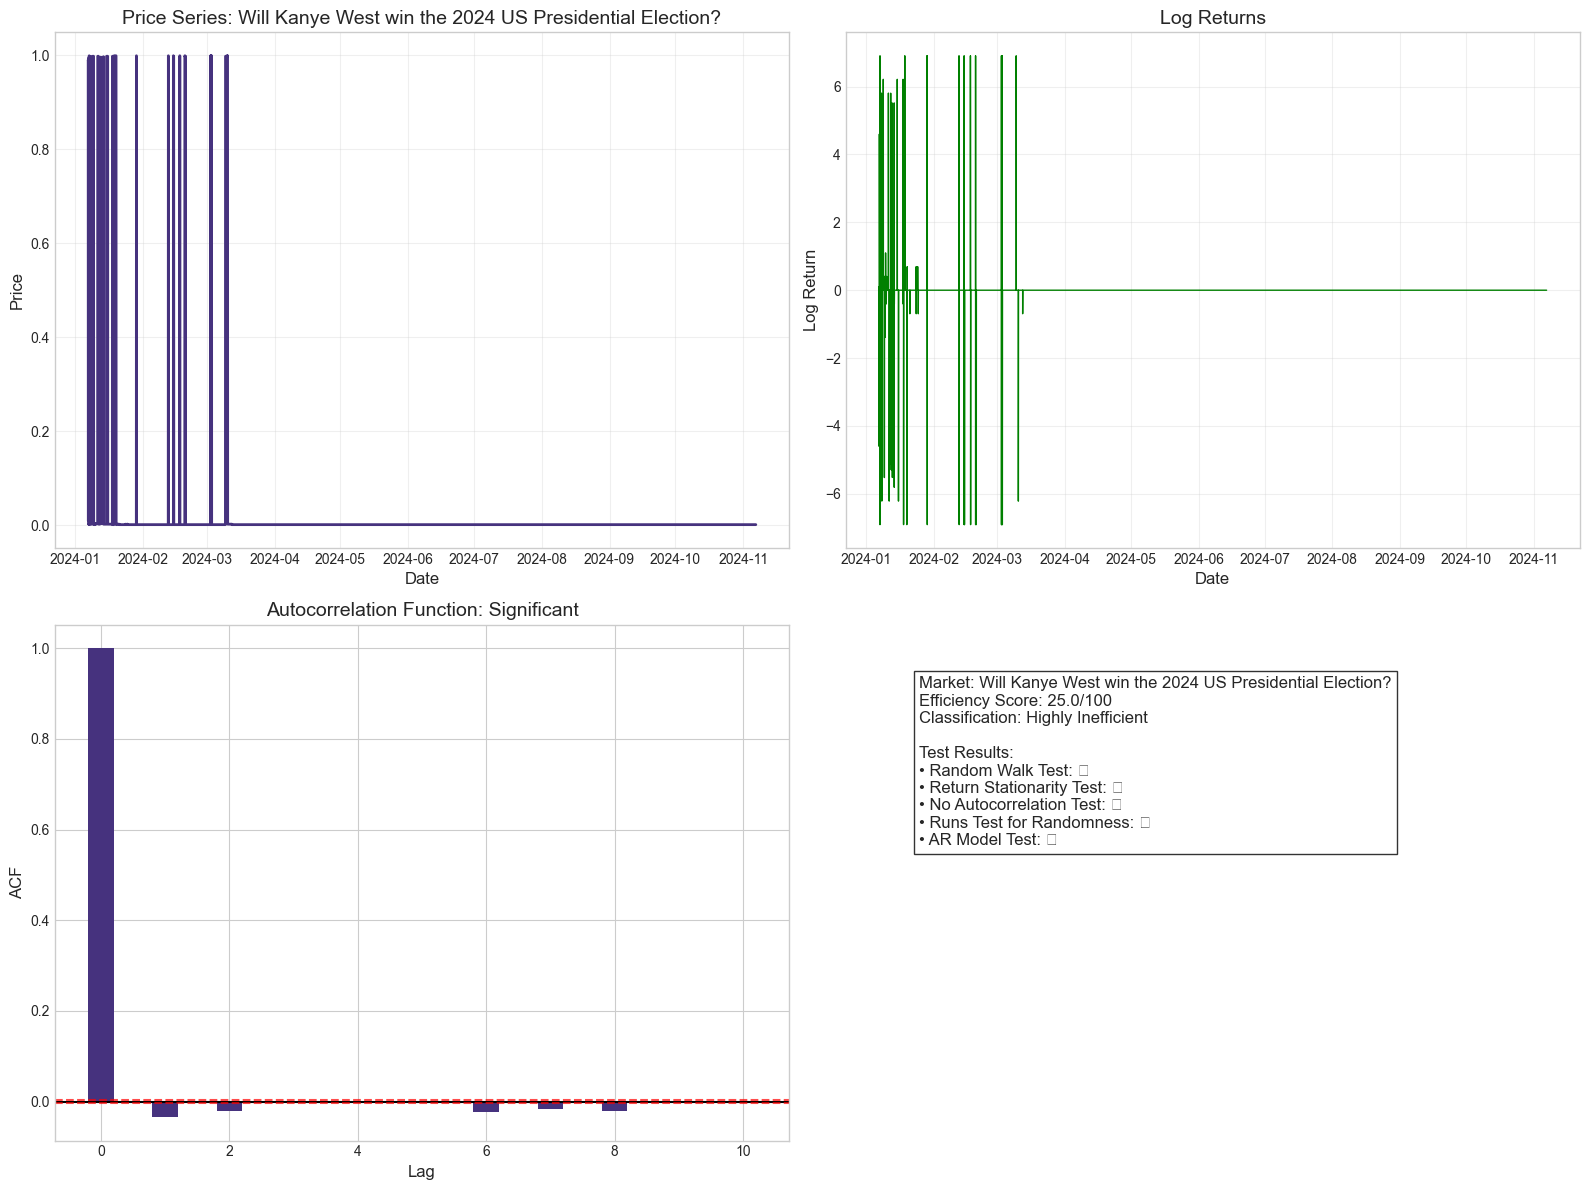

In [11]:

from run_market_efficiency import run_efficiency_analysis

results_list, summary = run_efficiency_analysis(MARKET_SELECTION, results_dir=results_dir, verbose=True)

# Display aggregate statistics
if summary and 'total_markets' in summary:
    # Create visualization of efficiency distribution
    plt.figure(figsize=(10, 6))
    
    # Extract efficiency scores from successful analyses
    efficiency_scores = [r.get('efficiency_score', 0) for r in results_list if r.get('analysis_success', False)]
    
    if efficiency_scores:
        # Create histogram with KDE
        sns.histplot(efficiency_scores, bins=10, kde=True)
        
        # Add mean and median lines
        plt.axvline(x=summary['avg_efficiency_score'], color='r', linestyle='--', 
                   label=f"Mean: {summary['avg_efficiency_score']:.2f}")
        plt.axvline(x=summary['median_efficiency_score'], color='g', linestyle='--', 
                   label=f"Median: {summary['median_efficiency_score']:.2f}")
        
        # Add classification regions
        plt.axvline(x=40, color='orange', linestyle=':', alpha=0.5)
        plt.axvline(x=60, color='orange', linestyle=':', alpha=0.5)
        plt.axvline(x=80, color='orange', linestyle=':', alpha=0.5)
        
        plt.text(20, 0.5, "Highly Inefficient", rotation=90, alpha=0.7)
        plt.text(50, 0.5, "Slightly Inefficient", rotation=90, alpha=0.7)
        plt.text(70, 0.5, "Moderately Efficient", rotation=90, alpha=0.7)
        plt.text(90, 0.5, "Highly Efficient", rotation=90, alpha=0.7)
        
        plt.title("Distribution of Market Efficiency Scores", fontsize=14)
        plt.xlabel("Efficiency Score", fontsize=12)
        plt.ylabel("Count", fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    # Create pie chart of classifications
    if 'classifications' in summary:
        plt.figure(figsize=(10, 6))
        
        # Extract labels and sizes
        labels = list(summary['classifications'].keys())
        sizes = list(summary['classifications'].values())
        colors = ['red', 'orange', 'lightgreen', 'green']
        
        # Create the pie chart
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
        plt.title("Market Efficiency Classification", fontsize=14)
        plt.show()
    
    # Create bar chart of test results
    if 'test_percentages' in summary:
        plt.figure(figsize=(12, 6))
        
        # Extract test names and percentages
        test_names = [test.replace('_', ' ').title() for test in summary['test_percentages'].keys()]
        percentages = list(summary['test_percentages'].values())
        
        # Create the bar chart
        bars = plt.bar(test_names, percentages, color='skyblue')
        
        # Add percentage labels
        for i, bar in enumerate(bars):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                   f"{percentages[i]:.1f}%", ha='center', va='bottom')
        
        plt.title("Percentage of Markets Passing Each Efficiency Test", fontsize=14)
        plt.ylabel("Percentage", fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 100)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
    # Add this cell to the notebook

# Generate detailed reports for all analyzed markets
if results_list and any(r.get('analysis_success', False) for r in results_list):
    print("\nGenerating detailed reports for all analyzed markets...")
    
    # Create directory for reports
    reports_dir = os.path.join(results_dir, "reports")
    os.makedirs(reports_dir, exist_ok=True)
    
    for result in results_list:
        if result.get('analysis_success', False):
            market_id = result.get('market_id', 'unknown')
            market_name = result.get('market_name', f"Market {market_id}")
            
            # Find the processed data for this market
            # Note: You would need to store this data during analysis
            # For now, we'll regenerate it
            
            trade_data = load_trade_data(market_id)
            if trade_data is not None:
                processed_data = analyzer.preprocess_market_data(trade_data)
                
                if processed_data is not None:
                    # Generate and save report
                    safe_name = ''.join(c if c.isalnum() else '_' for c in market_name)[:50]
                    report_path = os.path.join(reports_dir, f"market_{market_id}_{safe_name}_report.md")
                    analyzer.generate_detailed_report(result, processed_data, report_path)
    
    print(f"Reports saved to: {reports_dir}")

NameError: name 'results_list' is not defined